Loading NumPy feature files (.npy)...
 Loaded 500 videos
Example X shape: (31, 699)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75
Using: cuda


c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(


Epoch 1 | Train 0.1415 | Val 0.0302 | MSE 0.0313 | MAE 0.1400 | R² -0.4691 | Acc±0.1 44.53%
Epoch 2 | Train 0.0475 | Val 0.0270 | MSE 0.0284 | MAE 0.1338 | R² -0.3149 | Acc±0.1 48.27%
Epoch 3 | Train 0.0423 | Val 0.0250 | MSE 0.0262 | MAE 0.1293 | R² -0.2170 | Acc±0.1 46.93%
Epoch 4 | Train 0.0403 | Val 0.0251 | MSE 0.0263 | MAE 0.1288 | R² -0.2164 | Acc±0.1 47.73%
Epoch 5 | Train 0.0386 | Val 0.0224 | MSE 0.0234 | MAE 0.1212 | R² -0.0825 | Acc±0.1 48.53%
Epoch 6 | Train 0.0361 | Val 0.0223 | MSE 0.0233 | MAE 0.1211 | R² -0.0778 | Acc±0.1 50.13%
Epoch 7 | Train 0.0353 | Val 0.0206 | MSE 0.0215 | MAE 0.1161 | R² 0.0043 | Acc±0.1 52.00%
Epoch 8 | Train 0.0356 | Val 0.0212 | MSE 0.0221 | MAE 0.1175 | R² -0.0214 | Acc±0.1 49.33%
Epoch 9 | Train 0.0322 | Val 0.0217 | MSE 0.0226 | MAE 0.1182 | R² -0.0403 | Acc±0.1 50.67%
Epoch 10 | Train 0.0320 | Val 0.0194 | MSE 0.0201 | MAE 0.1112 | R² 0.0699 | Acc±0.1 54.67%
Epoch 11 | Train 0.0309 | Val 0.0202 | MSE 0.0210 | MAE 0.1136 | R² 0.0268 | Acc±

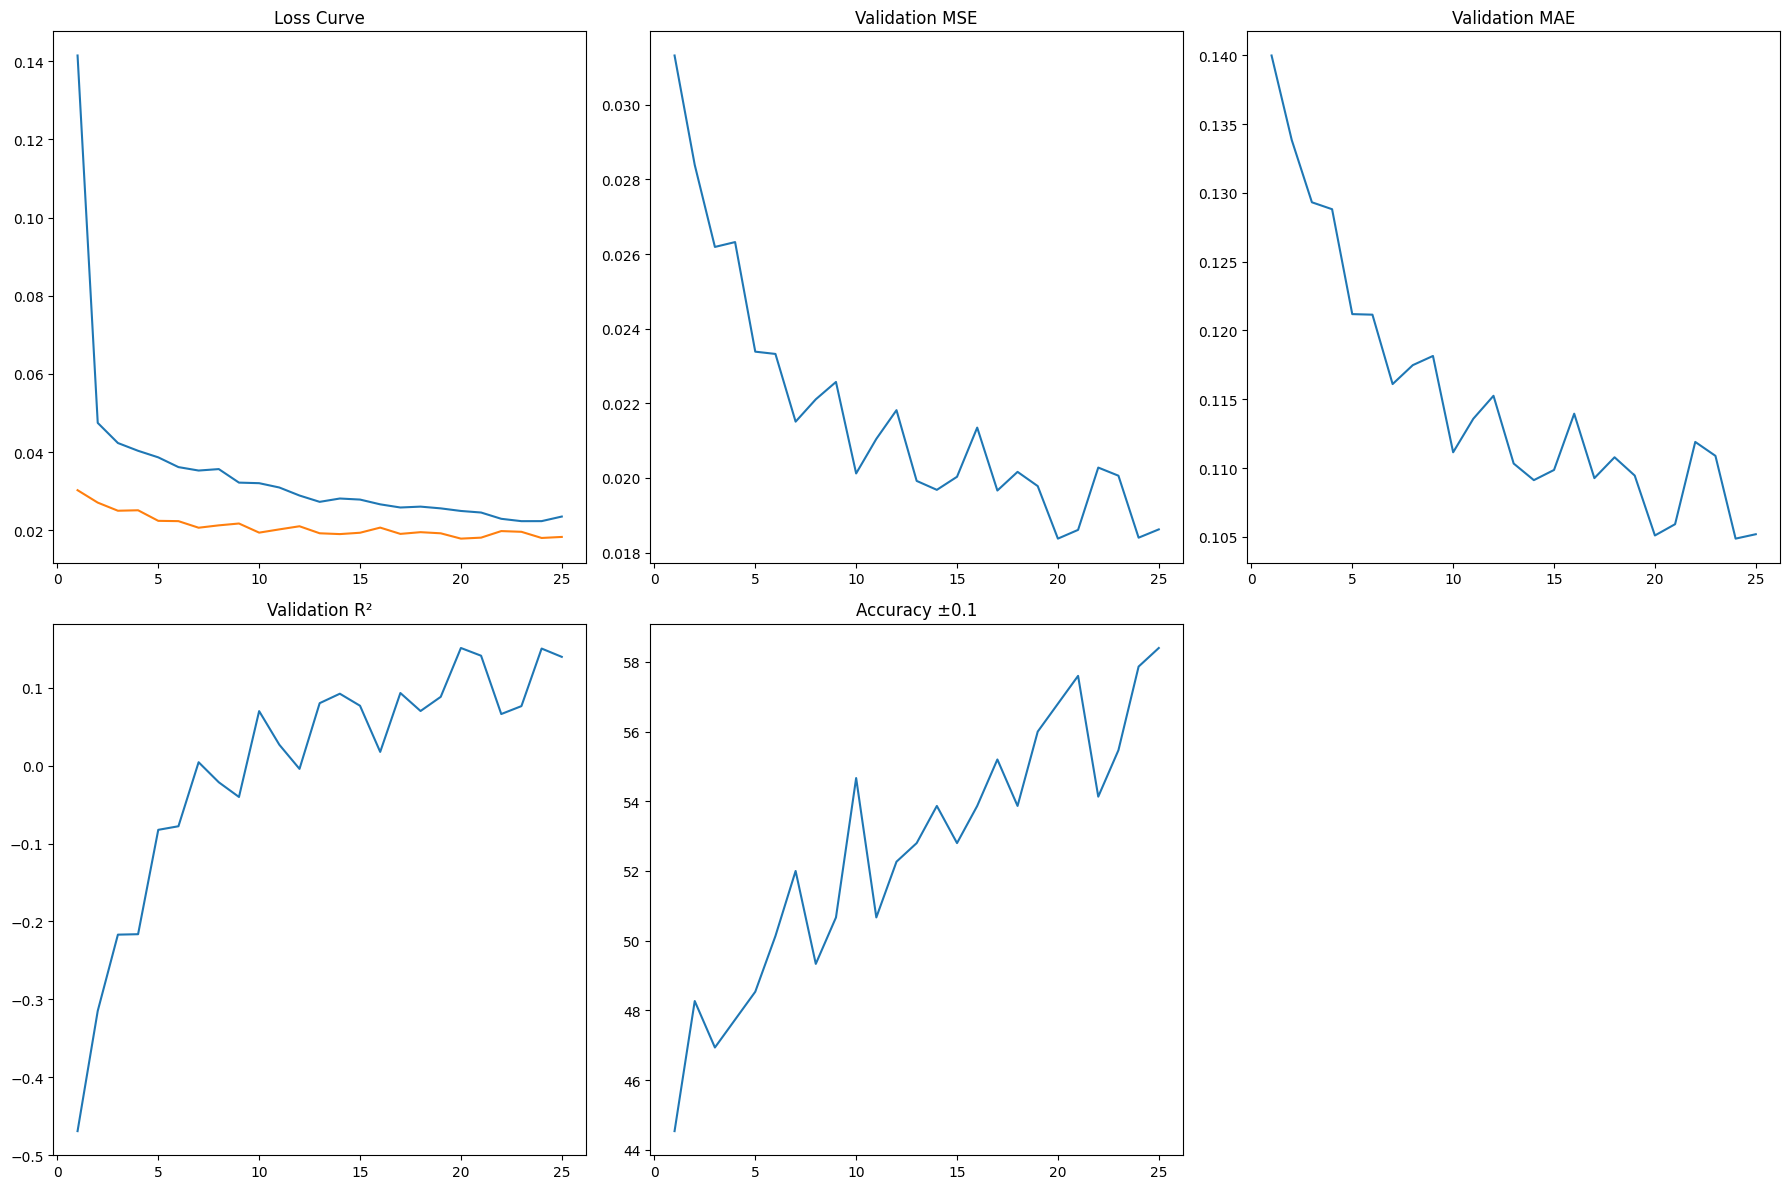


================= FINAL TEST RESULTS =================
MSE: 0.0178
MAE: 0.1048
R²:  0.1956
Accuracy ±0.1: 56.53%


In [ ]:
# ============================================================
# 📦 Install & Imports   (gru + encoder + transformer)
# ============================================================

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




seq_X_path  = "seq_X.npy"
seq_y_path  = "seq_y.npy"
seq_id_path = "seq_id.npy"

print("Loading NumPy feature files (.npy)...")

# np.load is the correct function for .npy files
# seq_X_raw is an array of objects (variable-length sequences), so allow_pickle=True is needed.
seq_X_raw = np.load(seq_X_path, allow_pickle=True)
seq_y_raw = np.load(seq_y_path, allow_pickle=True)
seq_id = np.load(seq_id_path, allow_pickle=True)


# Convert to correct types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y_cleaned = [arr[0] for arr in seq_y_raw] 
seq_y = np.array(seq_y_cleaned, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f" Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])

# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 Encoders + BiGRU + Transformer Model
# ============================================================
class OceanEncBiGRUTransformer(nn.Module):
    def __init__(
        self,
        input_dim,
        clip_dim=512,
        audio_dim=187,
        clip_enc_dim=128,
        audio_enc_dim=128,
        d_model=256,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.2,
    ):
        super().__init__()

        self.clip_dim = clip_dim
        self.audio_dim = audio_dim
    

        # -------------------------
        # 🔹 Modality Encoders
        # -------------------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(clip_enc_dim),
        )

        self.audio_encoder = nn.Sequential(
            nn.Linear(audio_dim, audio_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(audio_enc_dim),
        )



        fused_dim = clip_enc_dim + audio_enc_dim

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
        )

        # -------------------------
        # 🔹 BiGRU
        # -------------------------
        self.bigru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.gru_ln = nn.LayerNorm(d_model)

        # -------------------------
        # 🔹 Transformer
        # -------------------------
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

        # -------------------------
        # 🔹 Regression Head
        # -------------------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),
        )

    def forward(self, x, mask):
        B, T, D = x.shape

        # Split modalities
        x_clip = x[:, :, 0:self.clip_dim]
        x_audio  = x[:, :, self.clip_dim : self.clip_dim + self.audio_dim] # indices 512 to 698

        # Encode modalities
        e_clip = self.clip_encoder(x_clip)
        e_audio  = self.audio_encoder(x_audio)

        fused = torch.cat([e_clip, e_audio], dim=-1)
        fused = self.fuse_proj(fused)

        # BiGRU
        gru_out, _ = self.bigru(fused)
        gru_out = self.gru_ln(gru_out)

        # CLS + Transformer
        cls_tok = self.cls_token.expand(B, 1, -1)
        seq = torch.cat([cls_tok, gru_out], dim=1)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)
        key_mask = (full_mask == 0)

        enc = self.encoder(seq, src_key_padding_mask=key_mask)
        cls_out = enc[:, 0]

        # Predict OCEAN
        return self.head(cls_out)


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Training Setup
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanEncBiGRUTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history   = []

val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []

best_val = float("inf")
patience = 10
pat_ctr = 0
EPOCHS = 25

# ============================================================
# 🏋️ Training Loop
# ============================================================
for epoch in range(1, EPOCHS + 1):

    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
            preds = model(x, mask)

            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print(" Early stopping triggered")
            break

model.load_state_dict(best_state)


# ============================================================
# 📈 Plot Metrics
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history)
plt.plot(epochs, val_loss_history)
plt.title("Loss Curve")

plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")